# Experiments 
In this notebook we'll develop some experiments about the performance of LSTM architecture vs TimesFM.

__Content__:
1. Load data and preparate for training
2. Train LSTM
3. Train TimesFM
4. Save results and discussion


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler , RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib.ticker import MaxNLocator
from functions import load_data,create_intervals,create_windows,smape

# Loss folder path images
loss_folder = 'C:/Users/criju/Documents/Cod-Thesis-2/baseline/loss-plots'
os.makedirs(loss_folder, exist_ok=True)

# Result folder path
result_folder = 'C:/Users/criju/Documents/Cod-Thesis-2/baseline/results'
os.makedirs(result_folder, exist_ok=True)


es_cb = EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)

## 1. Train LSTM 
Now we'll train LSTM with 3 windows sizes (7,14,21), 2 different forecast horizon (15,30) and for each interval we add the previous one.

In [10]:
# Load the dataset
df = load_data('C:/Users/criju/Documents/Cod-Thesis-2/data/serie.csv')

# One step ahead forecasting
def build_lstm_model(window_size):
    model = Sequential([
        Input(shape=(window_size, 1)),   # Capa Input explícita
        LSTM(32, activation='relu', dropout=0.2),
        Dense(32),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


# Multi-step forecasting
def build_lstm_model_multi(window_size,horizon_size):
    model = Sequential([
        LSTM(32, activation='relu', input_shape=(window_size, 1), dropout=0.2),
        Dense(32),
        Dense(horizon_size,activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Global variables
EPOCHS = 50 
BATCH_SIZE = 16    
HORIZONTE_1 = 15 
HORIZONTE_2 = 30
intervalos_ordenados = create_intervals(df)


### Train for windows size = 7


Iteración 1: Mejor época = 12, Loss = 0.0301
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Acumulando intervalos 1 a 1: MAE = 193.14, MSE = 83172.85


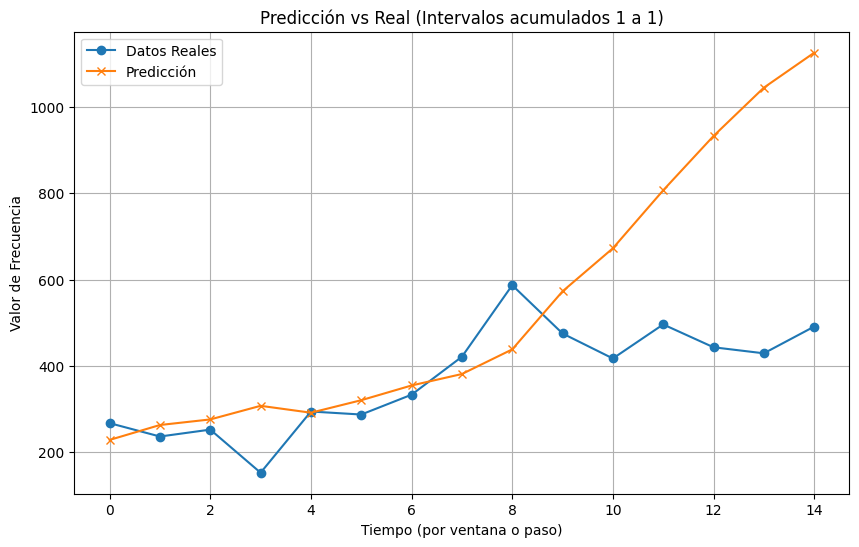

Iteración 2: Mejor época = 4, Loss = 0.2287
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Acumulando intervalos 1 a 2: MAE = 109.07, MSE = 19191.00


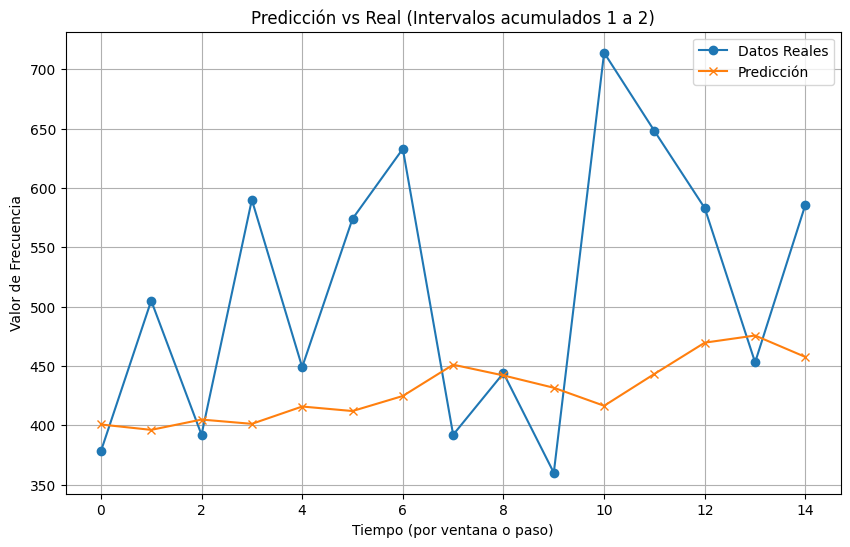

Iteración 3: Mejor época = 11, Loss = 0.1643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Acumulando intervalos 1 a 3: MAE = 229.46, MSE = 90391.78


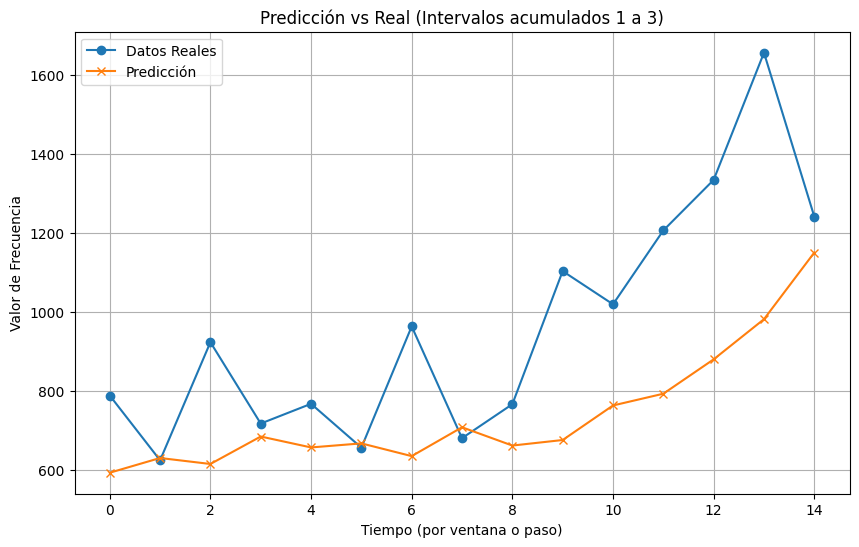

Iteración 4: Mejor época = 13, Loss = 0.2112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Acumulando intervalos 1 a 4: MAE = 65.60, MSE = 4341.47


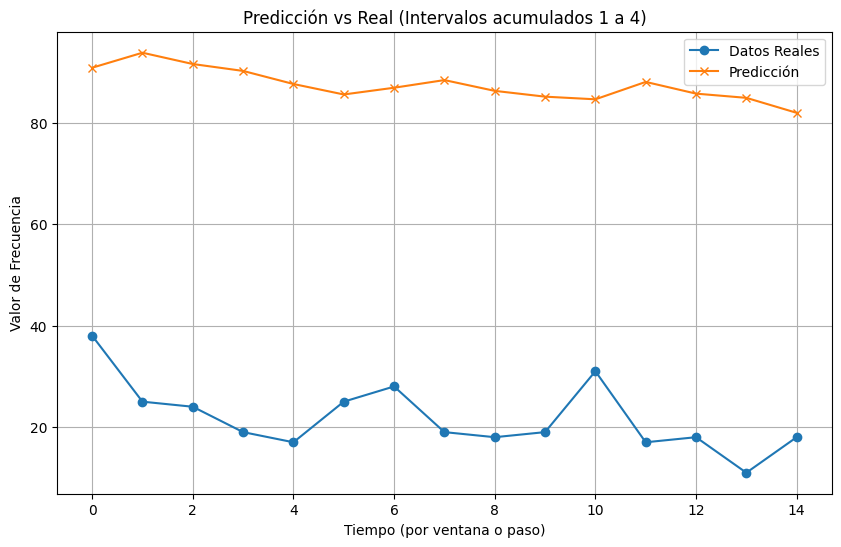

Iteración 5: Mejor época = 18, Loss = 0.1913
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Acumulando intervalos 1 a 5: MAE = 84.55, MSE = 9031.87


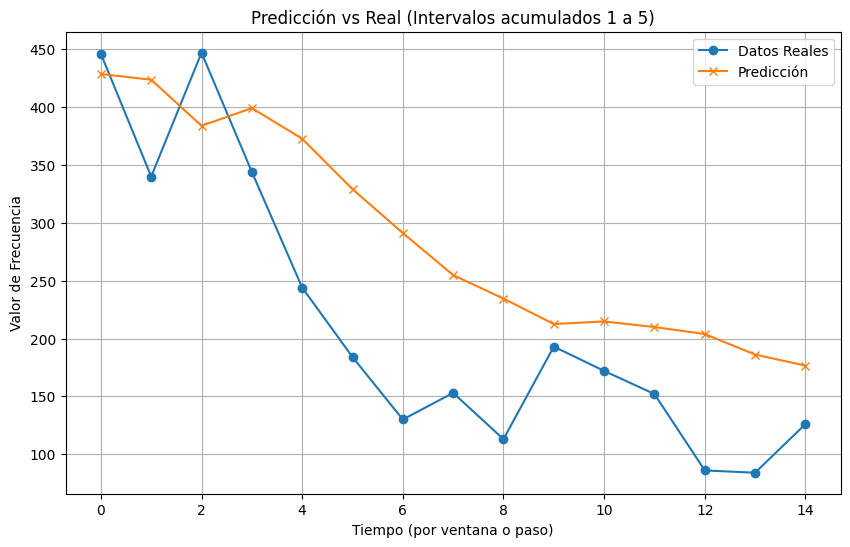

Iteración 6: Mejor época = 4, Loss = 0.2163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Acumulando intervalos 1 a 6: MAE = 28.74, MSE = 1078.35


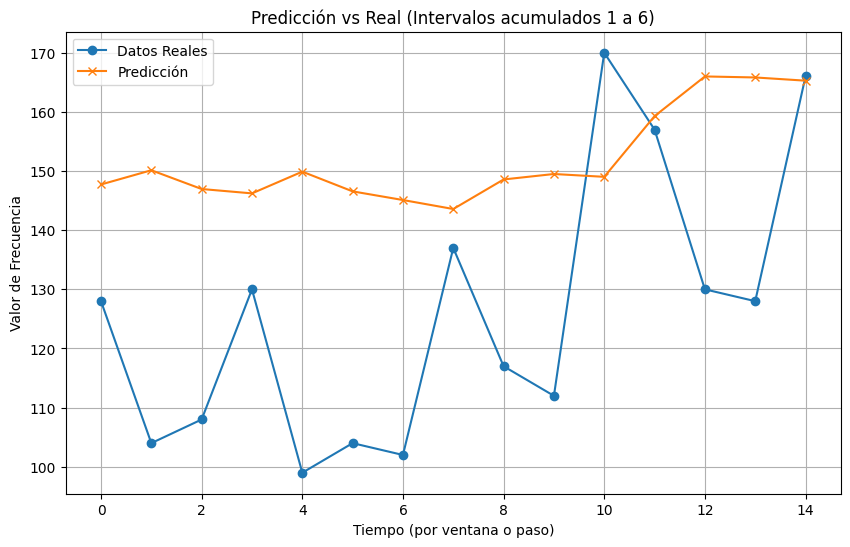

Iteración 7: Mejor época = 11, Loss = 0.2051
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Acumulando intervalos 1 a 7: MAE = 30.48, MSE = 1017.46


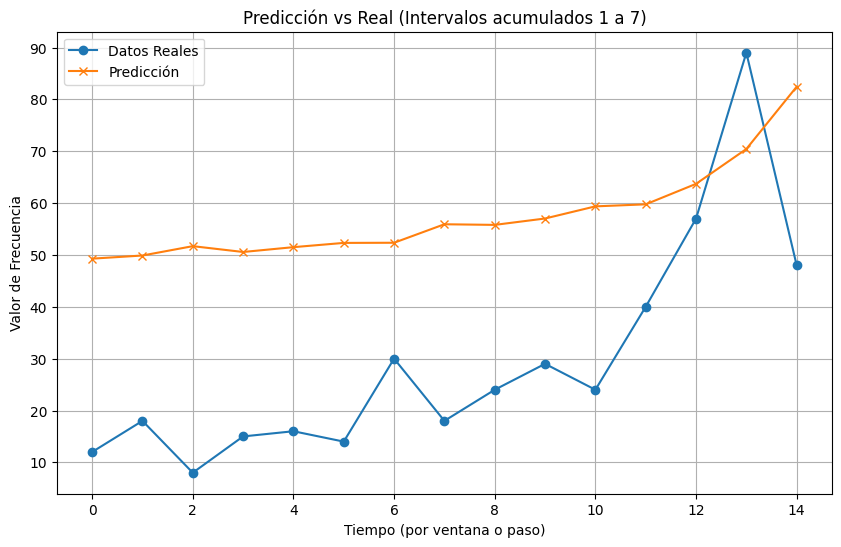

Iteración 8: Mejor época = 3, Loss = 0.2026
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Acumulando intervalos 1 a 8: MAE = 53.62, MSE = 2883.53


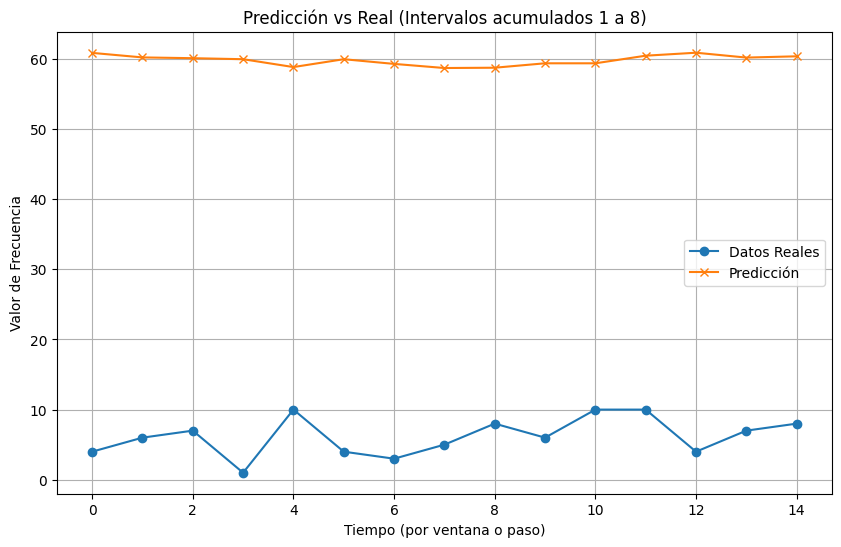


Resumen de métricas:
  Intervalos Acumulados         MAE           MSE       SMAPE
0      Intervalos 1 a 1  193.142229  83172.846564   33.792189
1      Intervalos 1 a 2  109.072917  19191.001557   21.665504
2      Intervalos 1 a 3  229.461938  90391.780153   24.574221
3      Intervalos 1 a 4   65.598123   4341.472514  121.316431
4      Intervalos 1 a 5   84.554713   9031.870220   40.313838
5      Intervalos 1 a 6   28.736251   1078.352854   21.661169
6      Intervalos 1 a 7   30.480337   1017.463904   80.311705
7      Intervalos 1 a 8   53.621560   2883.525993  162.986245


In [ ]:
WINDOW_SIZE = 7  
resultados = []

for i in range(len(intervalos_ordenados)):

    scaler = StandardScaler()
    model = build_lstm_model(WINDOW_SIZE) # Incializar el modelo LSTM


    # Tomando intervalo por intervalo
    intervalos_incluir = intervalos_ordenados[:i+1]
    df_accu = df[df['Intervalo'].isin(intervalos_incluir)]
    df_accu = df_accu.sort_values(by='Fecha')
    series = df_accu['Frecuencia'].values.reshape(-1, 1)

    # Normalizar los datos
    series_scaled = scaler.fit_transform(series)
    X,y = create_windows(series_scaled, window_size=WINDOW_SIZE)
    X_train , y_train = X[:-HORIZONTE_1], y[:-HORIZONTE_1]
    X_test , y_test = X[-HORIZONTE_1:], y[-HORIZONTE_1:]


    # Construimos y entrenamos el modelo
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es_cb],
        verbose=0
    )
    
    # 1) Encuentro la época de mínima pérdida
    loss_vals = history.history['loss']
    epochs_ran = len(loss_vals) 
    best_epoch = int(np.argmin(loss_vals)) + 1     
    best_loss = loss_vals[best_epoch-1]
    print(f"Iteración {i+1}: Mejor época = {best_epoch}, Loss = {best_loss:.4f}")

    # 2) Grafico la curva de entrenamiento y marco la mejor época
    plt.figure(figsize=(8,5))
    ax = plt.gca()  # obtenemos el eje actual
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  
    plt.plot(range(1, epochs_ran+1), loss_vals, marker='o', label='Training loss')
    plt.axvline(best_epoch, color='gray', linestyle='--', label=f'Best epoch ({best_epoch})')
    plt.title(f"Pérdida durante el entrenamiento\nIntervalos 1 a {i+1}")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # 3) Guardo la figura en la carpeta
    # Construir la ruta completa a la subcarpeta
    subfolder_path = os.path.join(loss_folder, "7_15_loss")
    # Crear la subcarpeta
    os.makedirs(subfolder_path, exist_ok=True)
    plot_path = os.path.join(subfolder_path, f"7_15_loss_intervalos_1_{i+1}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close() 

    
    # Hacemos la predicción para el conjunto test
    y_pred_scaled = model.predict(X_test)
    
    # Invertimos la transformación del escalador para volver a los valores originales
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
    
    # Calculamos las métricas
    mae = mean_absolute_error(y_test_inv, y_pred)
    mse = mean_squared_error(y_test_inv, y_pred)
    smape_value = smape(y_test_inv, y_pred)

    resultados.append({
        'Intervalos Acumulados': f"Intervalos 1 a {i+1}",
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape_value
    })
    
    print(f"Acumulando intervalos 1 a {i+1}: MAE = {mae:.2f}, MSE = {mse:.2f}")
    
    # Graficar datos reales vs predicción para este intervalo
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inv, label="Datos Reales", marker='o')
    plt.plot(y_pred, label="Predicción", marker='x')
    plt.title(f"Predicción vs Real (Intervalos acumulados 1 a {i+1})")
    plt.xlabel("Tiempo (por ventana o paso)")
    plt.ylabel("Valor de Frecuencia")
    plt.legend()
    plt.grid(True)
    plt.show()


df_resultados = pd.DataFrame(resultados)
print("\nResumen de métricas:")
print(df_resultados) 


subfolder1_path = os.path.join(result_folder, "7_15_results")
os.makedirs(subfolder1_path, exist_ok=True)


# Ruta completa al archivo dentro de la subcarpeta
csv_path = os.path.join(subfolder1_path, "lstm_7_15.csv")

# Guardar el DataFrame en esa ruta
df_resultados.to_csv(csv_path, index=False)


Iteración 1: Mejor época = 46, Loss = 0.0039
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Acumulando intervalos 1 a 1: MAE = 4621.17, MSE = 96504956.55


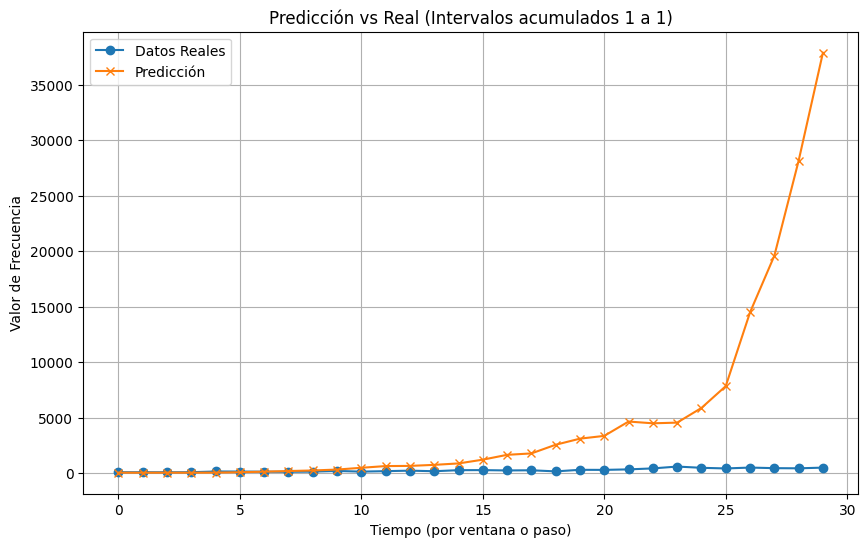

Iteración 2: Mejor época = 13, Loss = 0.1950
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Acumulando intervalos 1 a 2: MAE = 83.75, MSE = 11592.19


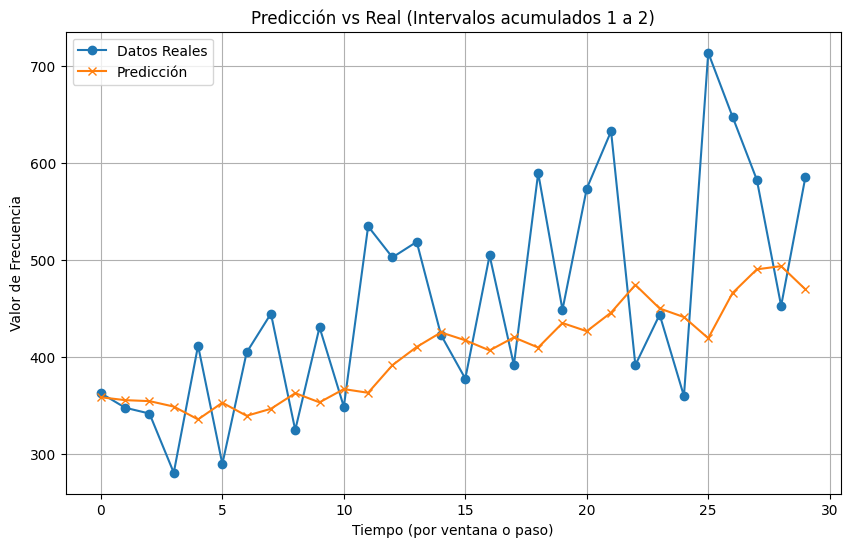

Iteración 3: Mejor época = 13, Loss = 0.1675
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Acumulando intervalos 1 a 3: MAE = 200.10, MSE = 70552.15


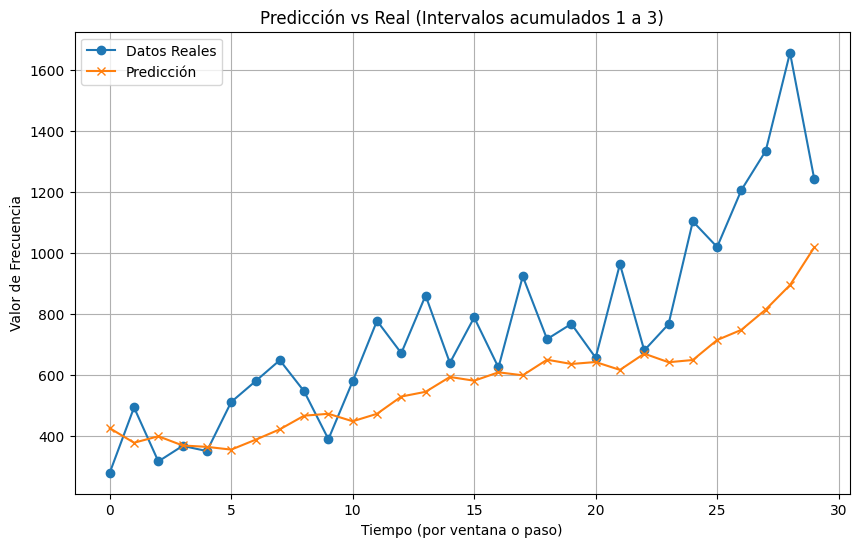

Iteración 4: Mejor época = 5, Loss = 0.2425
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Acumulando intervalos 1 a 4: MAE = 85.27, MSE = 7303.76


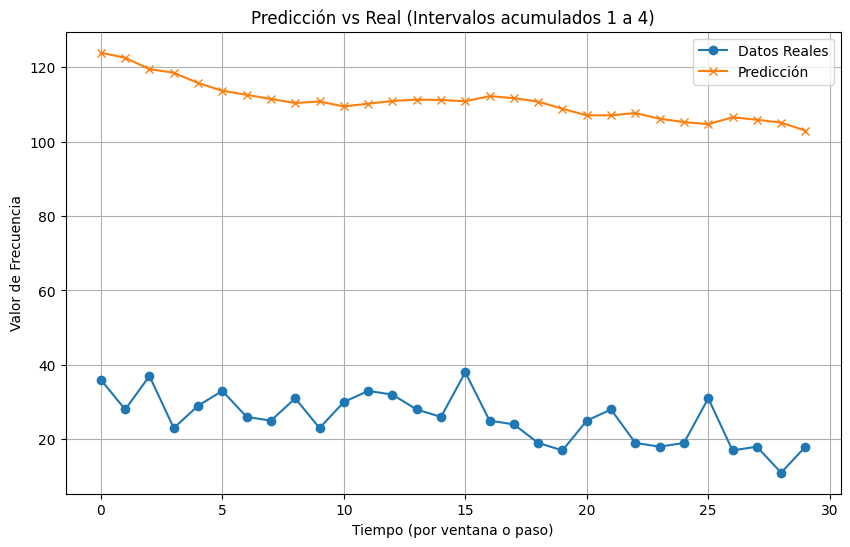

Iteración 5: Mejor época = 4, Loss = 0.2233
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Acumulando intervalos 1 a 5: MAE = 127.66, MSE = 22069.26


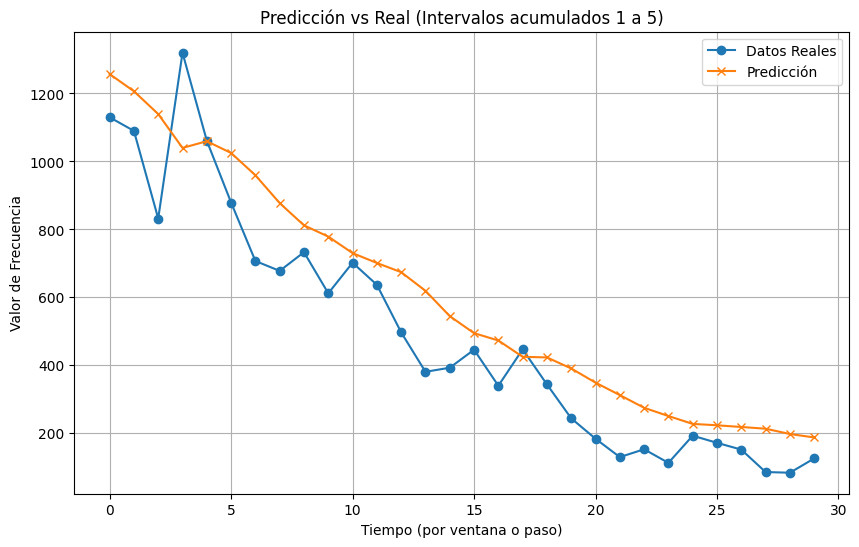

Iteración 6: Mejor época = 6, Loss = 0.2293
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Acumulando intervalos 1 a 6: MAE = 50.07, MSE = 2904.98


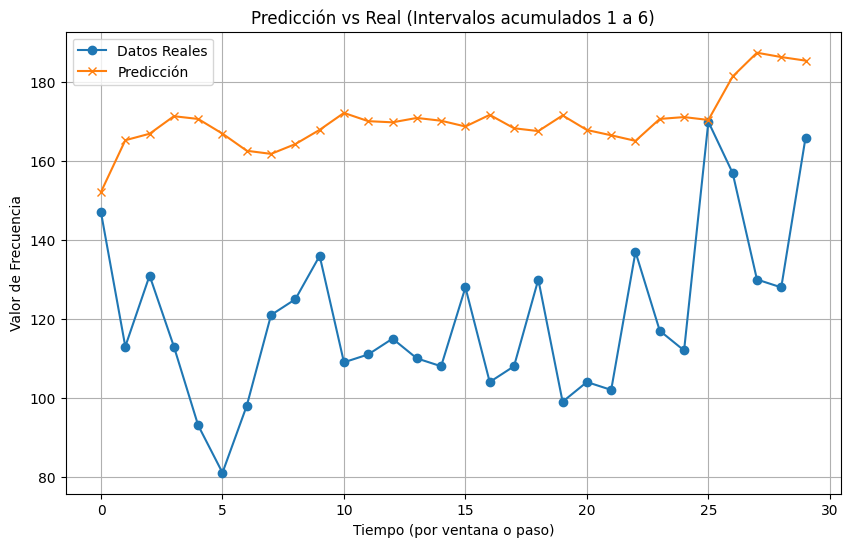

Iteración 7: Mejor época = 16, Loss = 0.1826
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Acumulando intervalos 1 a 7: MAE = 63.63, MSE = 4189.51


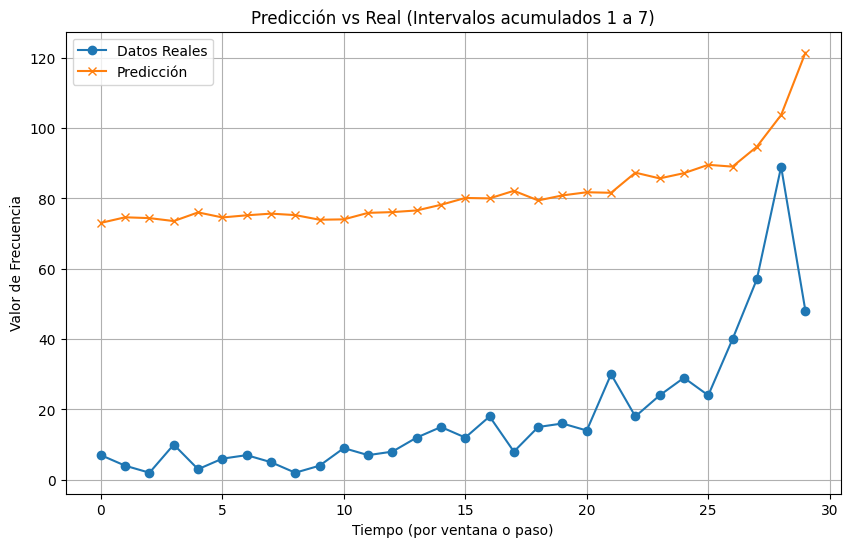

Iteración 8: Mejor época = 18, Loss = 0.2075
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Acumulando intervalos 1 a 8: MAE = 39.88, MSE = 1599.49


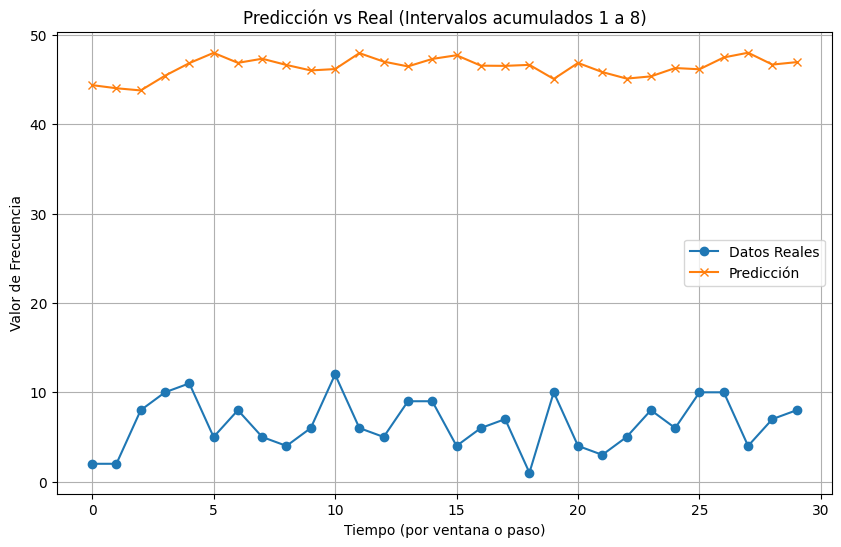


Resumen de métricas:
  Intervalos Acumulados          MAE           MSE       SMAPE
0      Intervalos 1 a 1  4621.169119  9.650496e+07  124.616082
1      Intervalos 1 a 2    83.745255  1.159219e+04   18.285214
2      Intervalos 1 a 3   200.103207  7.055215e+04   27.647990
3      Intervalos 1 a 4    85.272151  7.303760e+03  125.968626
4      Intervalos 1 a 5   127.659484  2.206926e+04   32.710851
5      Intervalos 1 a 6    50.066928  2.904978e+03   35.546505
6      Intervalos 1 a 7    63.625680  4.189513e+03  138.287711
7      Intervalos 1 a 8    39.880475  1.599493e+03  151.842003


In [21]:
WINDOW_SIZE = 7  
resultados = []

for i in range(len(intervalos_ordenados)):

    scaler = StandardScaler()
    model = build_lstm_model(WINDOW_SIZE) # Incializar el modelo LSTM


    # Tomando intervalo por intervalo
    intervalos_incluir = intervalos_ordenados[:i+1]
    df_accu = df[df['Intervalo'].isin(intervalos_incluir)]
    df_accu = df_accu.sort_values(by='Fecha')
    series = df_accu['Frecuencia'].values.reshape(-1, 1)

    # Normalizar los datos
    series_scaled = scaler.fit_transform(series)
    X,y = create_windows(series_scaled, window_size=WINDOW_SIZE)
    X_train , y_train = X[:-HORIZONTE_2], y[:-HORIZONTE_2]
    X_test , y_test = X[-HORIZONTE_2:], y[-HORIZONTE_2:]


    # Construimos y entrenamos el modelo
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es_cb],
        verbose=0
    )
    
    # 1) Encuentro la época de mínima pérdida
    loss_vals = history.history['loss']
    epochs_ran = len(loss_vals) 
    best_epoch = int(np.argmin(loss_vals)) + 1     
    best_loss = loss_vals[best_epoch-1]
    print(f"Iteración {i+1}: Mejor época = {best_epoch}, Loss = {best_loss:.4f}")

    # 2) Grafico la curva de entrenamiento y marco la mejor época
    plt.figure(figsize=(8,5))
    ax = plt.gca()  # obtenemos el eje actual
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  
    plt.plot(range(1, epochs_ran+1), loss_vals, marker='o', label='Training loss')
    plt.axvline(best_epoch, color='gray', linestyle='--', label=f'Best epoch ({best_epoch})')
    plt.title(f"Pérdida durante el entrenamiento\nIntervalos 1 a {i+1}")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # 3) Guardo la figura en la carpeta
    # Construir la ruta completa a la subcarpeta
    subfolder_path = os.path.join(loss_folder, "7_30_loss")
    # Crear la subcarpeta
    os.makedirs(subfolder_path, exist_ok=True)
    plot_path = os.path.join(subfolder_path, f"7_30_loss_intervalos_1_{i+1}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close() 

    
    # Hacemos la predicción para el conjunto test
    y_pred_scaled = model.predict(X_test)
    
    # Invertimos la transformación del escalador para volver a los valores originales
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
    
    # Calculamos las métricas
    mae = mean_absolute_error(y_test_inv, y_pred)
    mse = mean_squared_error(y_test_inv, y_pred)
    smape_value = smape(y_test_inv, y_pred)

    resultados.append({
        'Intervalos Acumulados': f"Intervalos 1 a {i+1}",
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape_value
    })
    
    print(f"Acumulando intervalos 1 a {i+1}: MAE = {mae:.2f}, MSE = {mse:.2f}")
    
    # Graficar datos reales vs predicción para este intervalo
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inv, label="Datos Reales", marker='o')
    plt.plot(y_pred, label="Predicción", marker='x')
    plt.title(f"Predicción vs Real (Intervalos acumulados 1 a {i+1})")
    plt.xlabel("Tiempo (por ventana o paso)")
    plt.ylabel("Valor de Frecuencia")
    plt.legend()
    plt.grid(True)
    plt.show()


df_resultados = pd.DataFrame(resultados)
print("\nResumen de métricas:")
print(df_resultados) 


subfolder1_path = os.path.join(result_folder, "7_30_results")
os.makedirs(subfolder1_path, exist_ok=True)


# Ruta completa al archivo dentro de la subcarpeta
csv_path = os.path.join(subfolder1_path, "lstm_7_30.csv")

# Guardar el DataFrame en esa ruta
df_resultados.to_csv(csv_path, index=False)


### Train for windows size = 14

Iteración 1: Mejor época = 11, Loss = 0.0274
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Acumulando intervalos 1 a 1: MAE = 297.10, MSE = 204675.42


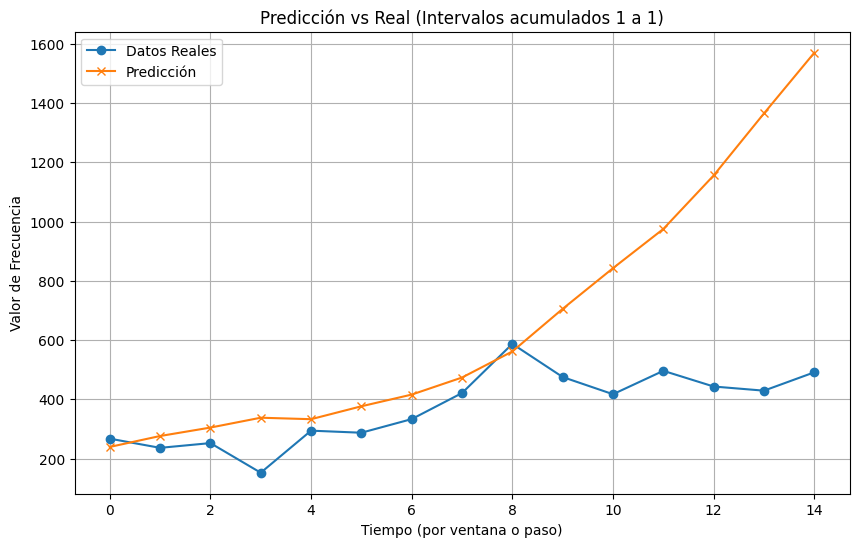

Iteración 2: Mejor época = 11, Loss = 0.1792
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Acumulando intervalos 1 a 2: MAE = 107.28, MSE = 18386.35


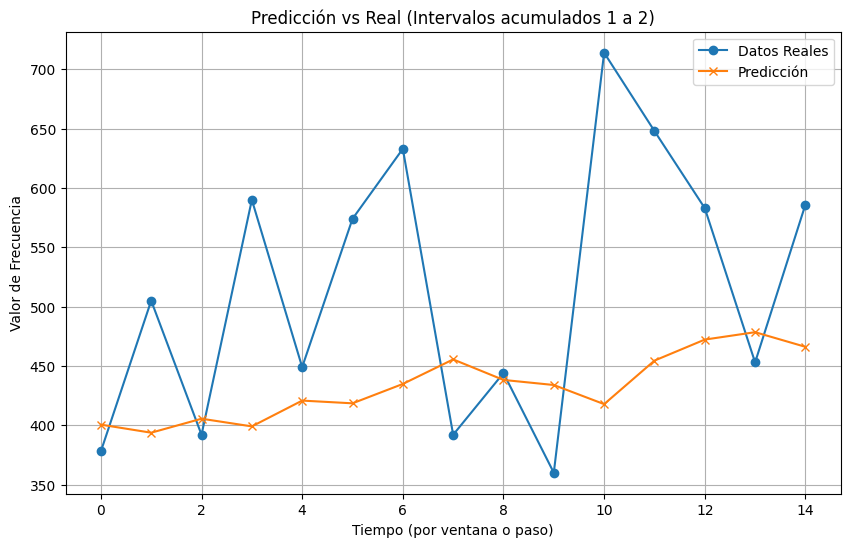

Iteración 3: Mejor época = 8, Loss = 0.1869
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Acumulando intervalos 1 a 3: MAE = 250.17, MSE = 104391.28


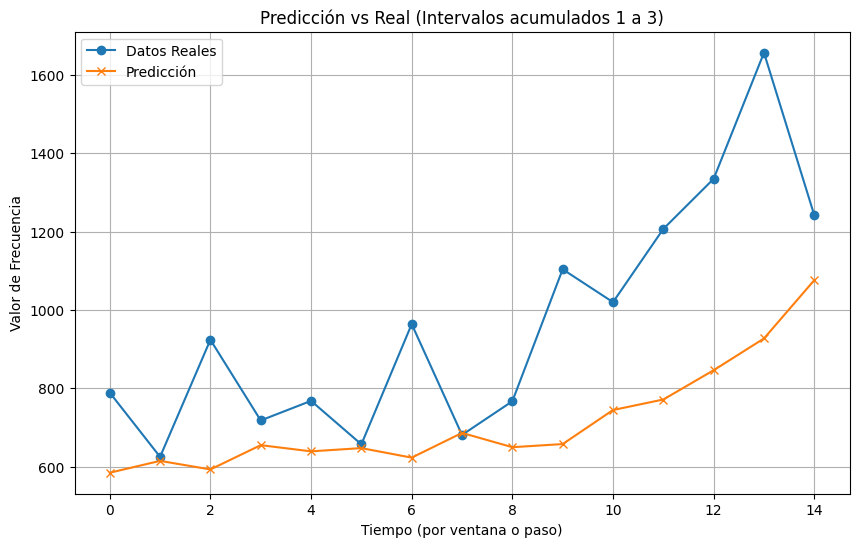

Iteración 4: Mejor época = 7, Loss = 0.2283
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Acumulando intervalos 1 a 4: MAE = 92.19, MSE = 8535.84


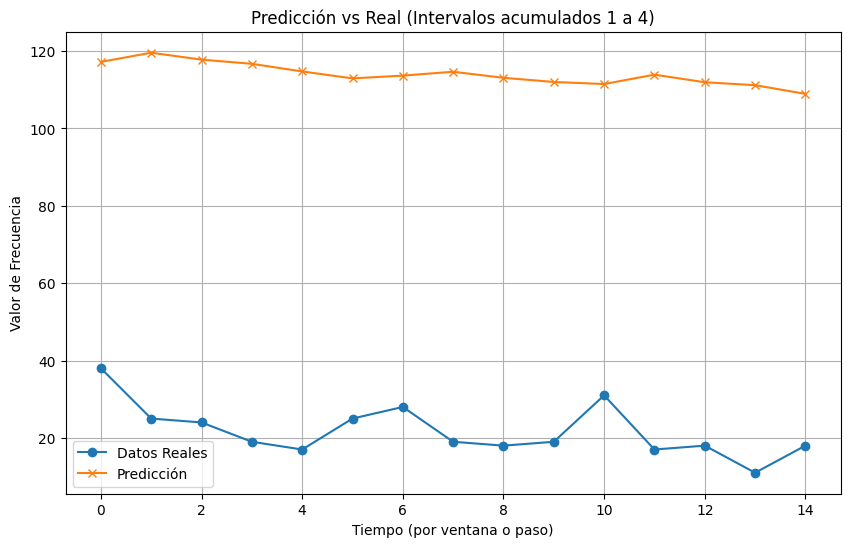

Iteración 5: Mejor época = 11, Loss = 0.2270
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Acumulando intervalos 1 a 5: MAE = 75.88, MSE = 7337.08


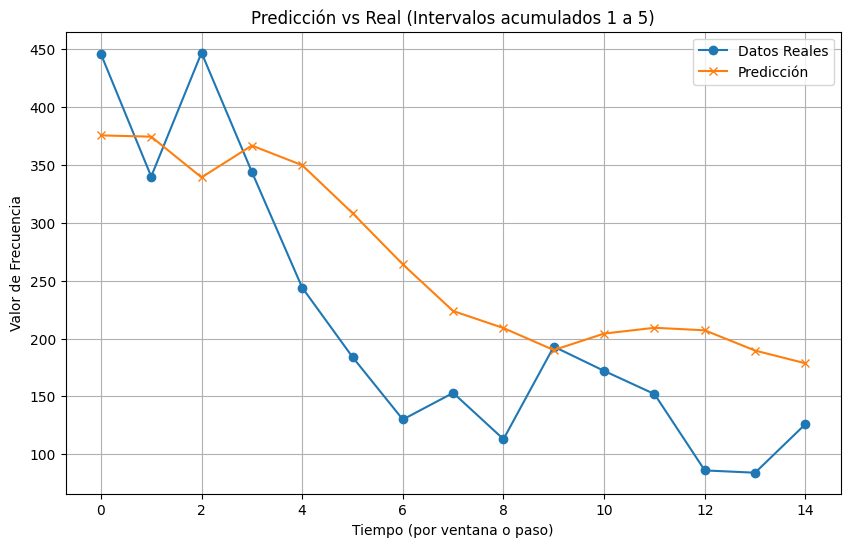

Iteración 6: Mejor época = 6, Loss = 0.2324
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Acumulando intervalos 1 a 6: MAE = 34.91, MSE = 1501.19


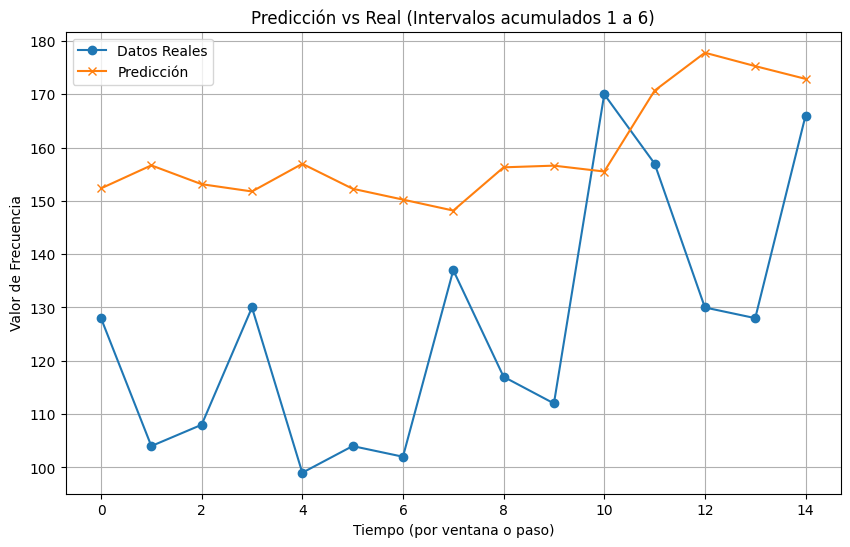

Iteración 7: Mejor época = 9, Loss = 0.2094
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Acumulando intervalos 1 a 7: MAE = 29.18, MSE = 935.94


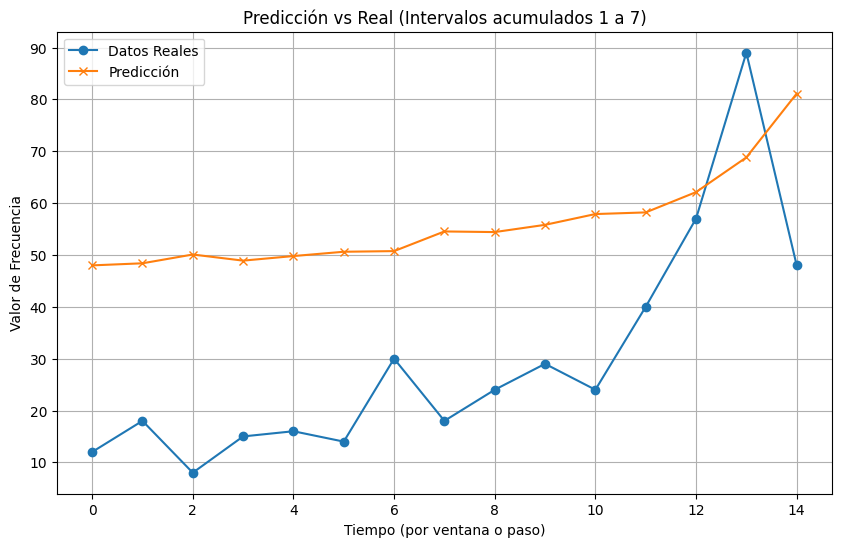

Iteración 8: Mejor época = 24, Loss = 0.1822
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Acumulando intervalos 1 a 8: MAE = 40.23, MSE = 1627.47


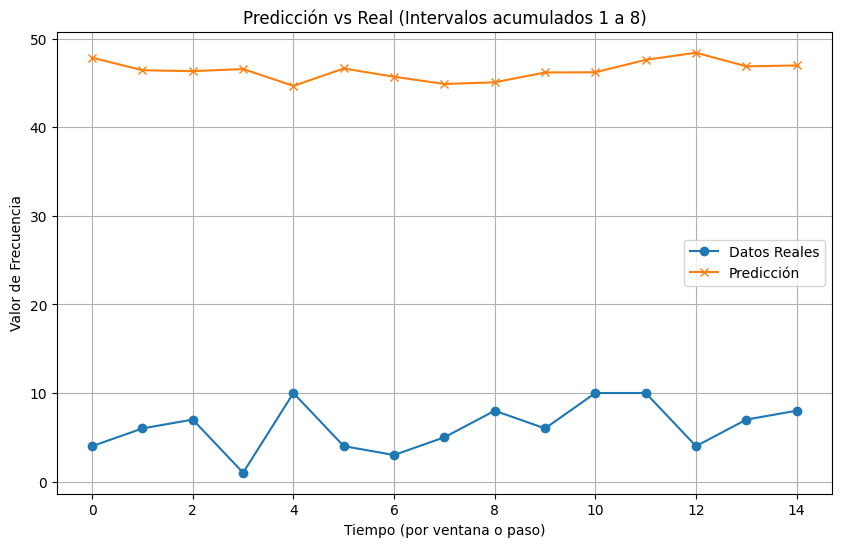


Resumen de métricas:
  Intervalos Acumulados         MAE            MSE       SMAPE
0      Intervalos 1 a 1  297.102791  204675.423733   44.583999
1      Intervalos 1 a 2  107.282035   18386.345695   21.274395
2      Intervalos 1 a 3  250.168042  104391.276646   27.058786
3      Intervalos 1 a 4   92.191727    8535.838079  136.608219
4      Intervalos 1 a 5   75.881237    7337.077690   37.117165
5      Intervalos 1 a 6   34.907926    1501.190079   25.492053
6      Intervalos 1 a 7   29.183711     935.938836   78.452327
7      Intervalos 1 a 8   40.227996    1627.468583  153.691669


In [22]:
WINDOW_SIZE =  14
resultados = []

for i in range(len(intervalos_ordenados)):

    scaler = StandardScaler()
    model = build_lstm_model(WINDOW_SIZE) # Incializar el modelo LSTM


    # Tomando intervalo por intervalo
    intervalos_incluir = intervalos_ordenados[:i+1]
    df_accu = df[df['Intervalo'].isin(intervalos_incluir)]
    df_accu = df_accu.sort_values(by='Fecha')
    series = df_accu['Frecuencia'].values.reshape(-1, 1)

    # Normalizar los datos
    series_scaled = scaler.fit_transform(series)
    X,y = create_windows(series_scaled, window_size=WINDOW_SIZE)
    X_train , y_train = X[:-HORIZONTE_1], y[:-HORIZONTE_1]
    X_test , y_test = X[-HORIZONTE_1:], y[-HORIZONTE_1:]


    # Construimos y entrenamos el modelo
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es_cb],
        verbose=0
    )
    
    # 1) Encuentro la época de mínima pérdida
    loss_vals = history.history['loss']
    epochs_ran = len(loss_vals) 
    best_epoch = int(np.argmin(loss_vals)) + 1     
    best_loss = loss_vals[best_epoch-1]
    print(f"Iteración {i+1}: Mejor época = {best_epoch}, Loss = {best_loss:.4f}")

    # 2) Grafico la curva de entrenamiento y marco la mejor época
    plt.figure(figsize=(8,5))
    ax = plt.gca()  # obtenemos el eje actual
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  
    plt.plot(range(1, epochs_ran+1), loss_vals, marker='o', label='Training loss')
    plt.axvline(best_epoch, color='gray', linestyle='--', label=f'Best epoch ({best_epoch})')
    plt.title(f"Pérdida durante el entrenamiento\nIntervalos 1 a {i+1}")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # 3) Guardo la figura en la carpeta
    # Construir la ruta completa a la subcarpeta
    subfolder_path = os.path.join(loss_folder, "14_15_loss")
    # Crear la subcarpeta
    os.makedirs(subfolder_path, exist_ok=True)
    plot_path = os.path.join(subfolder_path, f"14_15_loss_intervalos_1_{i+1}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close() 

    
    # Hacemos la predicción para el conjunto test
    y_pred_scaled = model.predict(X_test)
    
    # Invertimos la transformación del escalador para volver a los valores originales
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
    
    # Calculamos las métricas
    mae = mean_absolute_error(y_test_inv, y_pred)
    mse = mean_squared_error(y_test_inv, y_pred)
    smape_value = smape(y_test_inv, y_pred)

    resultados.append({
        'Intervalos Acumulados': f"Intervalos 1 a {i+1}",
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape_value
    })
    
    print(f"Acumulando intervalos 1 a {i+1}: MAE = {mae:.2f}, MSE = {mse:.2f}")
    
    # Graficar datos reales vs predicción para este intervalo
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inv, label="Datos Reales", marker='o')
    plt.plot(y_pred, label="Predicción", marker='x')
    plt.title(f"Predicción vs Real (Intervalos acumulados 1 a {i+1})")
    plt.xlabel("Tiempo (por ventana o paso)")
    plt.ylabel("Valor de Frecuencia")
    plt.legend()
    plt.grid(True)
    plt.show()


df_resultados = pd.DataFrame(resultados)
print("\nResumen de métricas:")
print(df_resultados) 


subfolder1_path = os.path.join(result_folder, "14_15_results")
os.makedirs(subfolder1_path, exist_ok=True)


# Ruta completa al archivo dentro de la subcarpeta
csv_path = os.path.join(subfolder1_path, "lstm_14_15.csv")

# Guardar el DataFrame en esa ruta
df_resultados.to_csv(csv_path, index=False)


Iteración 1: Mejor época = 38, Loss = 0.0046
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Acumulando intervalos 1 a 1: MAE = 695.06, MSE = 2220762.58


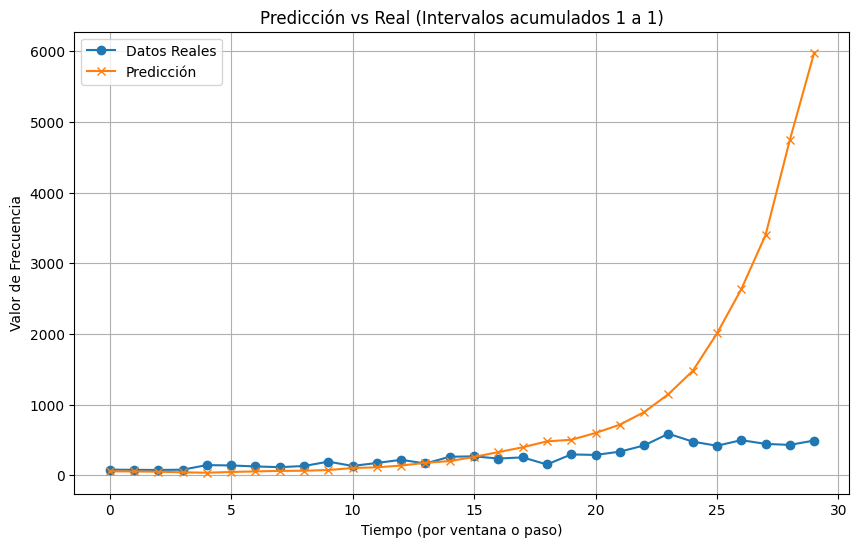

Iteración 2: Mejor época = 24, Loss = 0.2061
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Acumulando intervalos 1 a 2: MAE = 87.18, MSE = 13174.24


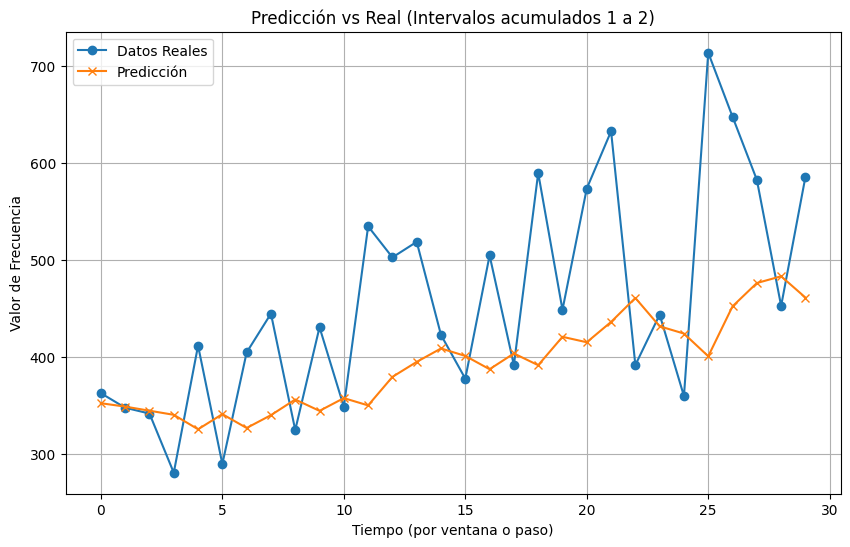

Iteración 3: Mejor época = 3, Loss = 0.1723
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Acumulando intervalos 1 a 3: MAE = 215.81, MSE = 78187.92


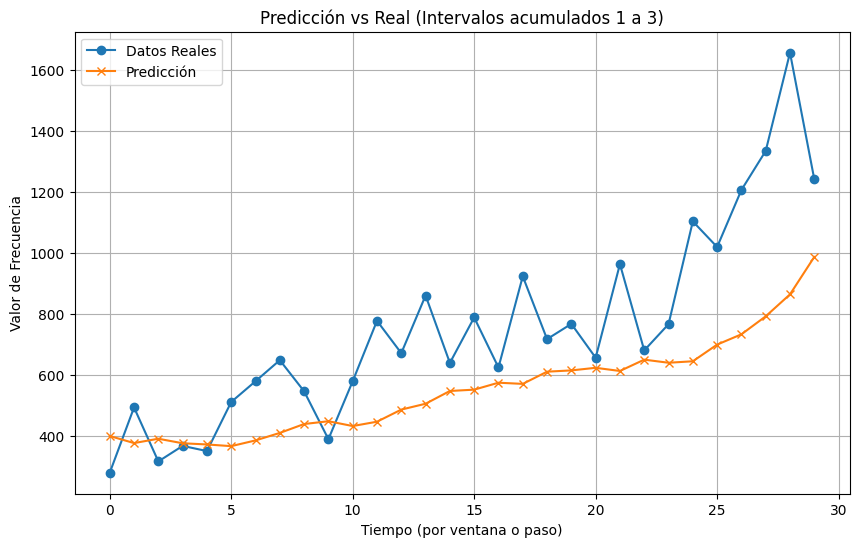

Iteración 4: Mejor época = 6, Loss = 0.2219
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Acumulando intervalos 1 a 4: MAE = 83.29, MSE = 6969.68


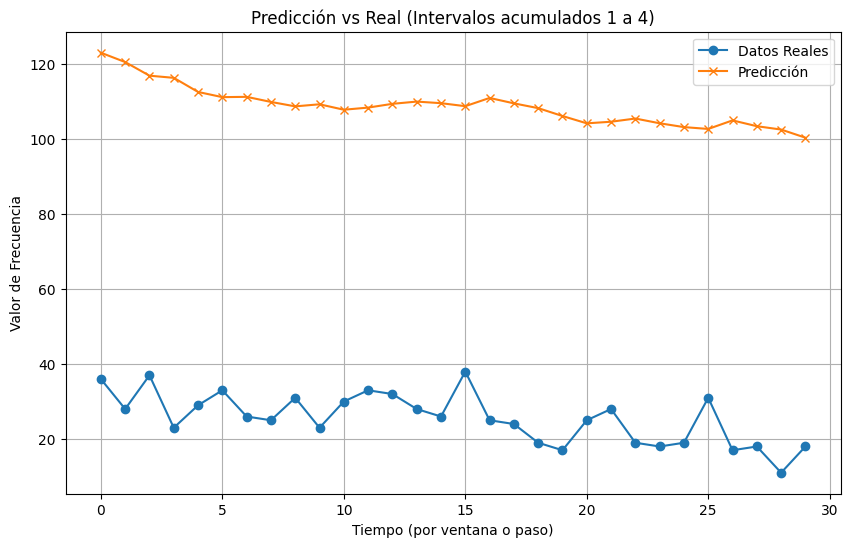

Iteración 5: Mejor época = 24, Loss = 0.2185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Acumulando intervalos 1 a 5: MAE = 117.26, MSE = 20222.28


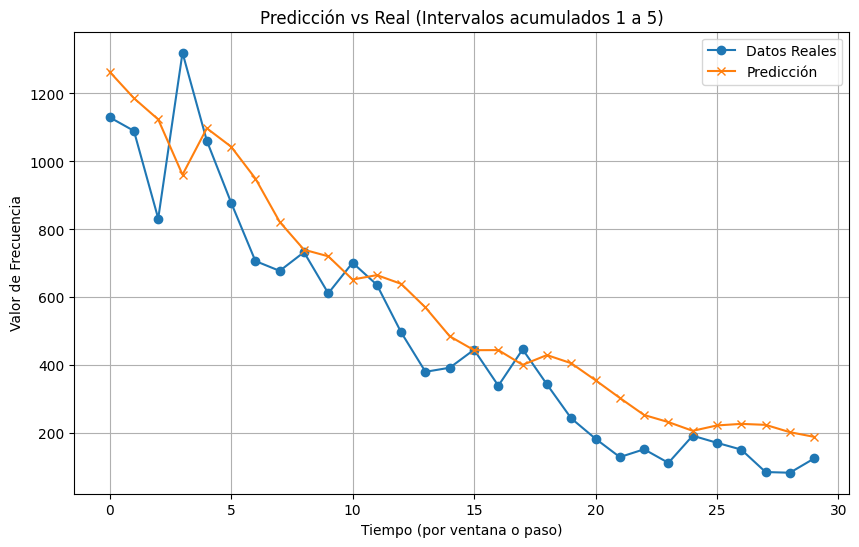

Iteración 6: Mejor época = 21, Loss = 0.2008
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Acumulando intervalos 1 a 6: MAE = 44.19, MSE = 2334.80


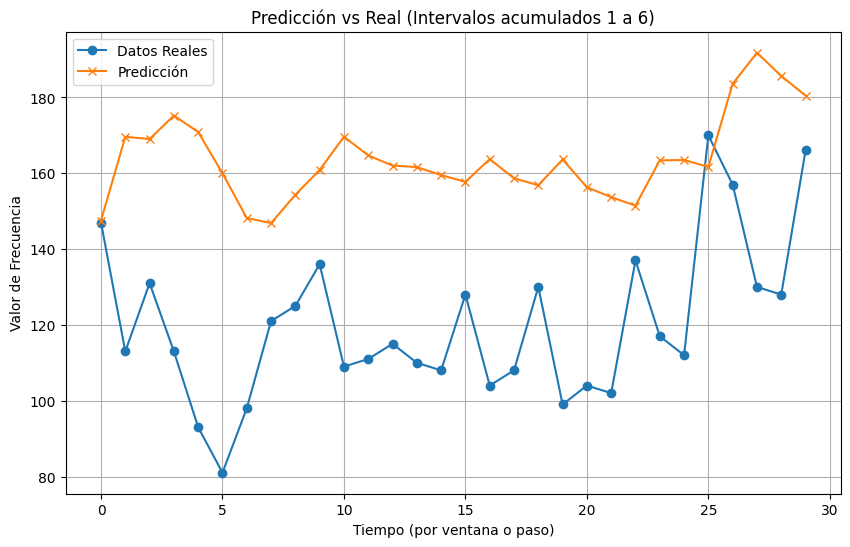

Iteración 7: Mejor época = 7, Loss = 0.2153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Acumulando intervalos 1 a 7: MAE = 63.52, MSE = 4170.78


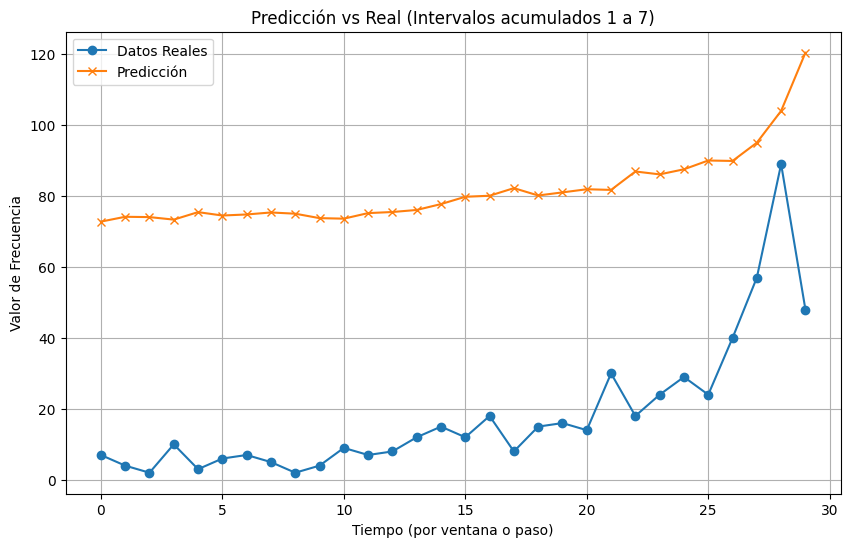

Iteración 8: Mejor época = 10, Loss = 0.2167
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Acumulando intervalos 1 a 8: MAE = 40.85, MSE = 1678.30


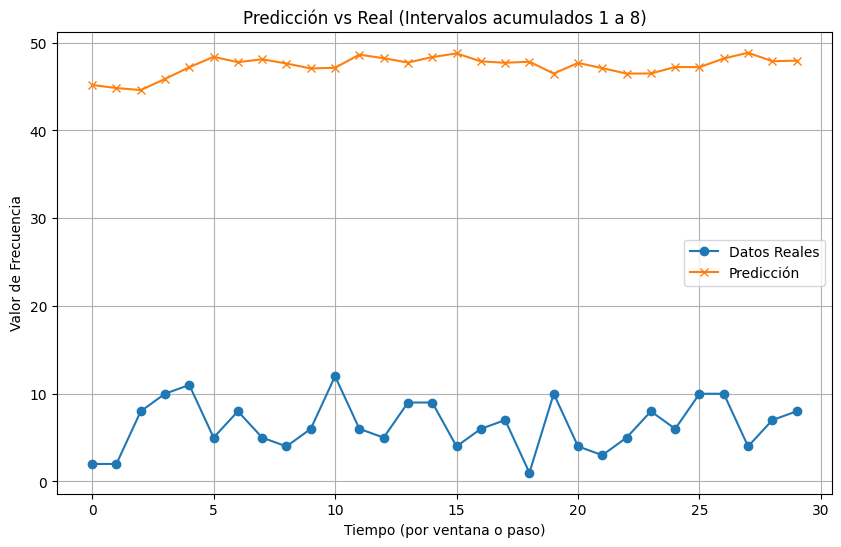


Resumen de métricas:
  Intervalos Acumulados         MAE           MSE       SMAPE
0      Intervalos 1 a 1  695.058873  2.220763e+06   73.894433
1      Intervalos 1 a 2   87.182712  1.317424e+04   19.104168
2      Intervalos 1 a 3  215.811726  7.818792e+04   30.125439
3      Intervalos 1 a 4   83.292233  6.969684e+03  124.894744
4      Intervalos 1 a 5  117.261518  2.022228e+04   30.779059
5      Intervalos 1 a 6   44.189546  2.334797e+03   32.029804
6      Intervalos 1 a 7   63.517633  4.170783e+03  138.287524
7      Intervalos 1 a 8   40.854790  1.678297e+03  152.690357


In [23]:
WINDOW_SIZE =  14
resultados = []

for i in range(len(intervalos_ordenados)):

    scaler = StandardScaler()
    model = build_lstm_model(WINDOW_SIZE) # Incializar el modelo LSTM


    # Tomando intervalo por intervalo
    intervalos_incluir = intervalos_ordenados[:i+1]
    df_accu = df[df['Intervalo'].isin(intervalos_incluir)]
    df_accu = df_accu.sort_values(by='Fecha')
    series = df_accu['Frecuencia'].values.reshape(-1, 1)

    # Normalizar los datos
    series_scaled = scaler.fit_transform(series)
    X,y = create_windows(series_scaled, window_size=WINDOW_SIZE)
    X_train , y_train = X[:-HORIZONTE_2], y[:-HORIZONTE_2]
    X_test , y_test = X[-HORIZONTE_2:], y[-HORIZONTE_2:]


    # Construimos y entrenamos el modelo
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es_cb],
        verbose=0
    )
    
    # 1) Encuentro la época de mínima pérdida
    loss_vals = history.history['loss']
    epochs_ran = len(loss_vals) 
    best_epoch = int(np.argmin(loss_vals)) + 1     
    best_loss = loss_vals[best_epoch-1]
    print(f"Iteración {i+1}: Mejor época = {best_epoch}, Loss = {best_loss:.4f}")

    # 2) Grafico la curva de entrenamiento y marco la mejor época
    plt.figure(figsize=(8,5))
    ax = plt.gca()  # obtenemos el eje actual
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  
    plt.plot(range(1, epochs_ran+1), loss_vals, marker='o', label='Training loss')
    plt.axvline(best_epoch, color='gray', linestyle='--', label=f'Best epoch ({best_epoch})')
    plt.title(f"Pérdida durante el entrenamiento\nIntervalos 1 a {i+1}")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # 3) Guardo la figura en la carpeta
    # Construir la ruta completa a la subcarpeta
    subfolder_path = os.path.join(loss_folder, "14_30_loss")
    # Crear la subcarpeta
    os.makedirs(subfolder_path, exist_ok=True)
    plot_path = os.path.join(subfolder_path, f"14_30_loss_intervalos_1_{i+1}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close() 

    
    # Hacemos la predicción para el conjunto test
    y_pred_scaled = model.predict(X_test)
    
    # Invertimos la transformación del escalador para volver a los valores originales
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
    
    # Calculamos las métricas
    mae = mean_absolute_error(y_test_inv, y_pred)
    mse = mean_squared_error(y_test_inv, y_pred)
    smape_value = smape(y_test_inv, y_pred)

    resultados.append({
        'Intervalos Acumulados': f"Intervalos 1 a {i+1}",
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape_value
    })
    
    print(f"Acumulando intervalos 1 a {i+1}: MAE = {mae:.2f}, MSE = {mse:.2f}")
    
    # Graficar datos reales vs predicción para este intervalo
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inv, label="Datos Reales", marker='o')
    plt.plot(y_pred, label="Predicción", marker='x')
    plt.title(f"Predicción vs Real (Intervalos acumulados 1 a {i+1})")
    plt.xlabel("Tiempo (por ventana o paso)")
    plt.ylabel("Valor de Frecuencia")
    plt.legend()
    plt.grid(True)
    plt.show()


df_resultados = pd.DataFrame(resultados)
print("\nResumen de métricas:")
print(df_resultados) 


subfolder1_path = os.path.join(result_folder, "14_30_results")
os.makedirs(subfolder1_path, exist_ok=True)


# Ruta completa al archivo dentro de la subcarpeta
csv_path = os.path.join(subfolder1_path, "lstm_14_30.csv")

# Guardar el DataFrame en esa ruta
df_resultados.to_csv(csv_path, index=False)


### Train for windows size = 21

Iteración 1: Mejor época = 39, Loss = 0.0162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Acumulando intervalos 1 a 1: MAE = 364.76, MSE = 368013.66


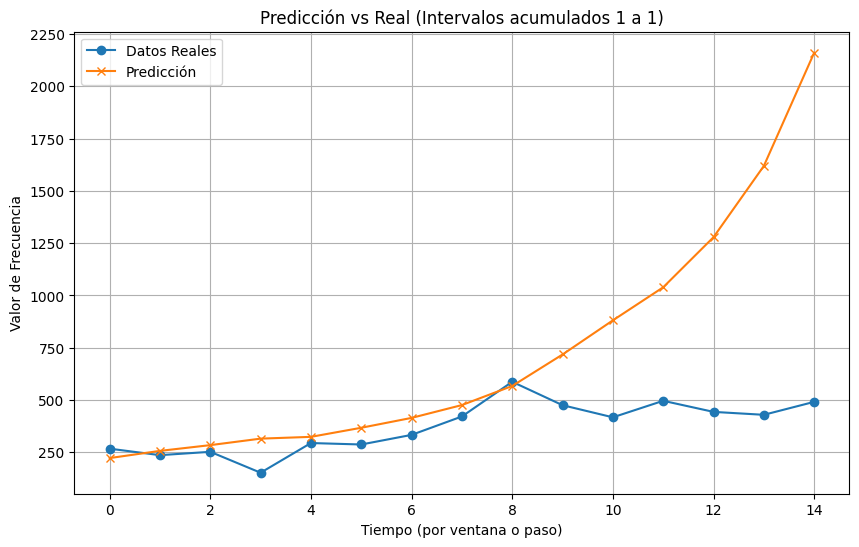

Iteración 2: Mejor época = 12, Loss = 0.2134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Acumulando intervalos 1 a 2: MAE = 105.77, MSE = 17539.91


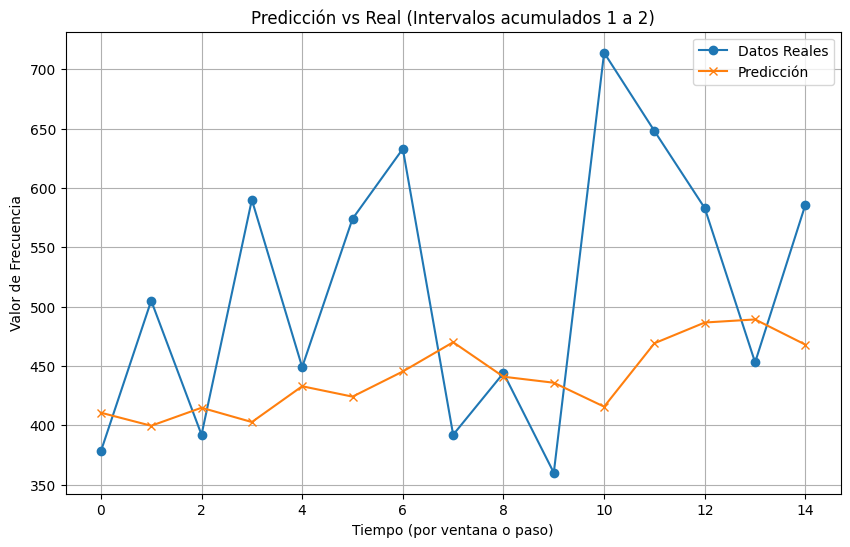

Iteración 3: Mejor época = 13, Loss = 0.1773
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Acumulando intervalos 1 a 3: MAE = 255.82, MSE = 107551.06


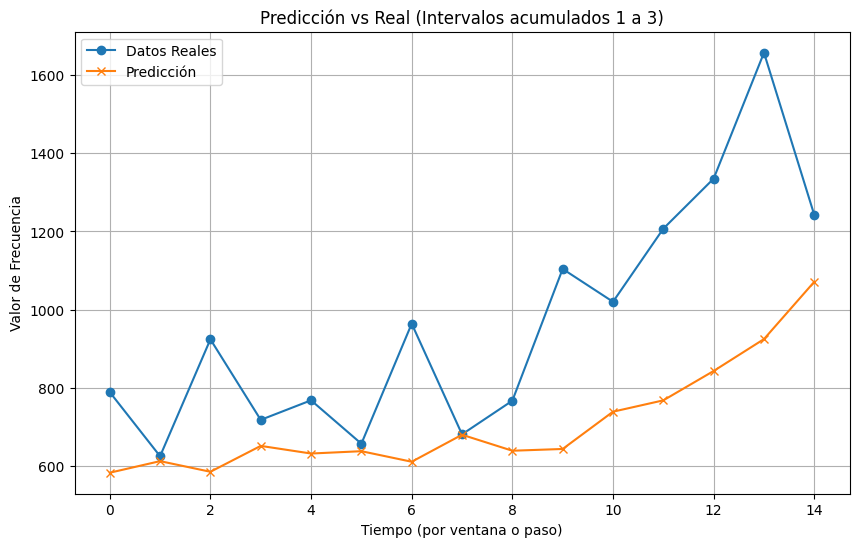

Iteración 4: Mejor época = 6, Loss = 0.2193
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
Acumulando intervalos 1 a 4: MAE = 82.28, MSE = 6806.26


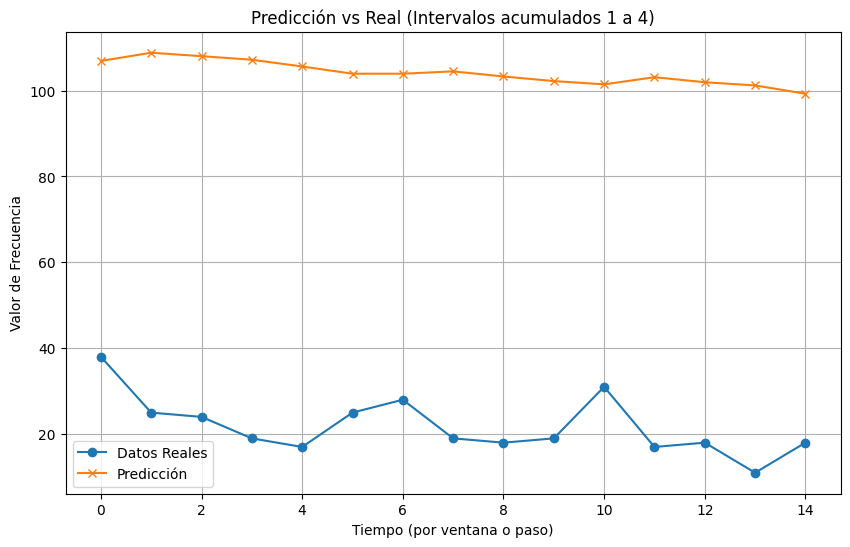

Iteración 5: Mejor época = 11, Loss = 0.2132
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
Acumulando intervalos 1 a 5: MAE = 68.57, MSE = 5990.86


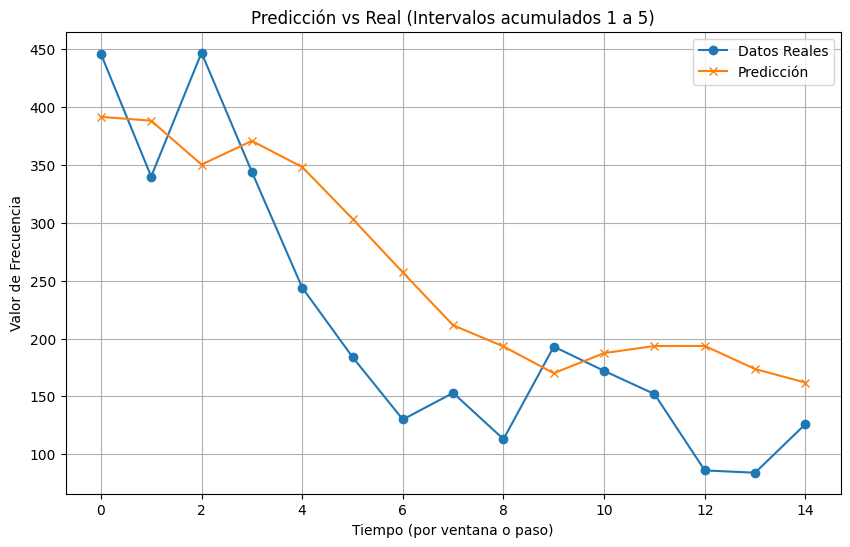

Iteración 6: Mejor época = 16, Loss = 0.2279
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Acumulando intervalos 1 a 6: MAE = 32.41, MSE = 1318.02


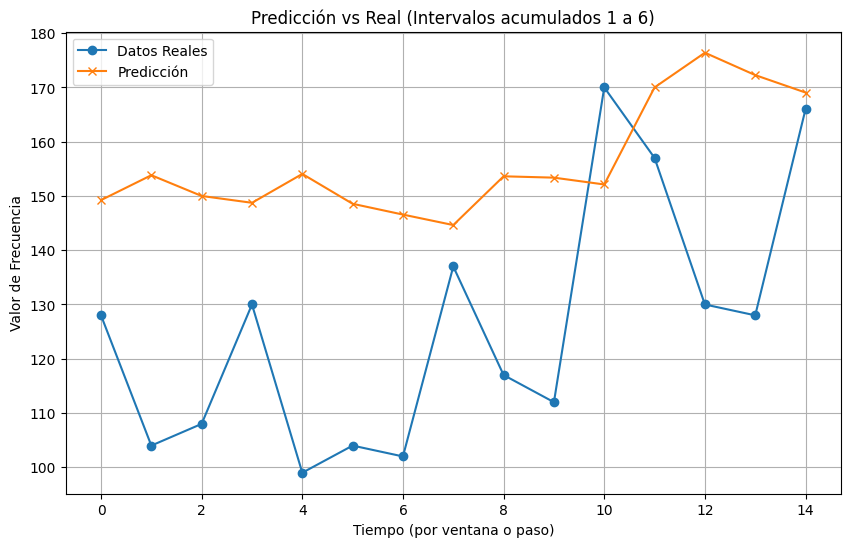

Iteración 7: Mejor época = 14, Loss = 0.1715
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Acumulando intervalos 1 a 7: MAE = 64.87, MSE = 4436.92


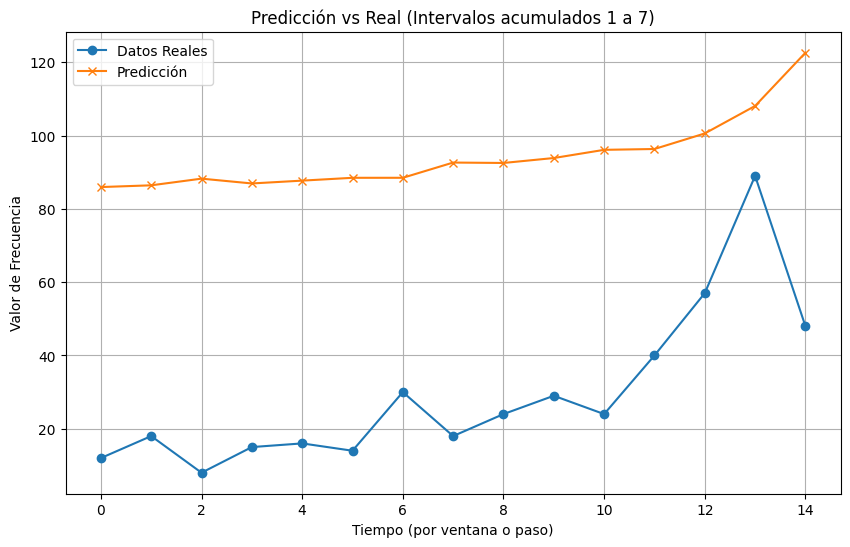

Iteración 8: Mejor época = 11, Loss = 0.2083
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Acumulando intervalos 1 a 8: MAE = 57.04, MSE = 3262.44


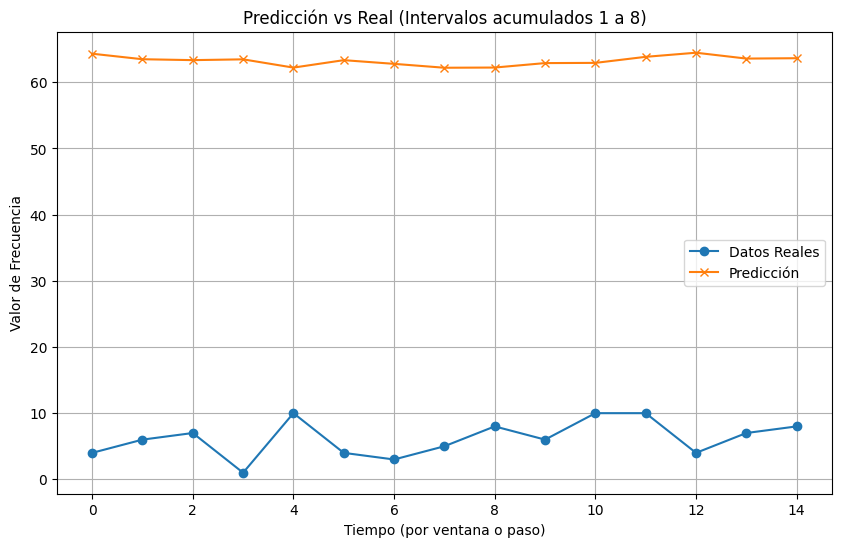


Resumen de métricas:
  Intervalos Acumulados         MAE            MSE       SMAPE
0      Intervalos 1 a 1  364.755773  368013.658193   46.804059
1      Intervalos 1 a 2  105.768878   17539.906953   20.950387
2      Intervalos 1 a 3  255.816650  107551.063683   27.874335
3      Intervalos 1 a 4   82.276765    6806.261013  131.661376
4      Intervalos 1 a 5   68.566095    5990.857789   33.934953
5      Intervalos 1 a 6   32.411752    1318.018111   23.928342
6      Intervalos 1 a 7   64.865973    4436.917756  113.019464
7      Intervalos 1 a 8   57.044272    3262.443869  164.781149


In [24]:
WINDOW_SIZE =  21
resultados = []

for i in range(len(intervalos_ordenados)):

    scaler = StandardScaler()
    model = build_lstm_model(WINDOW_SIZE) # Incializar el modelo LSTM


    # Tomando intervalo por intervalo
    intervalos_incluir = intervalos_ordenados[:i+1]
    df_accu = df[df['Intervalo'].isin(intervalos_incluir)]
    df_accu = df_accu.sort_values(by='Fecha')
    series = df_accu['Frecuencia'].values.reshape(-1, 1)

    # Normalizar los datos
    series_scaled = scaler.fit_transform(series)
    X,y = create_windows(series_scaled, window_size=WINDOW_SIZE)
    X_train , y_train = X[:-HORIZONTE_1], y[:-HORIZONTE_1]
    X_test , y_test = X[-HORIZONTE_1:], y[-HORIZONTE_1:]


    # Construimos y entrenamos el modelo
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es_cb],
        verbose=0
    )
    
    # 1) Encuentro la época de mínima pérdida
    loss_vals = history.history['loss']
    epochs_ran = len(loss_vals) 
    best_epoch = int(np.argmin(loss_vals)) + 1     
    best_loss = loss_vals[best_epoch-1]
    print(f"Iteración {i+1}: Mejor época = {best_epoch}, Loss = {best_loss:.4f}")

    # 2) Grafico la curva de entrenamiento y marco la mejor época
    plt.figure(figsize=(8,5))
    ax = plt.gca()  # obtenemos el eje actual
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  
    plt.plot(range(1, epochs_ran+1), loss_vals, marker='o', label='Training loss')
    plt.axvline(best_epoch, color='gray', linestyle='--', label=f'Best epoch ({best_epoch})')
    plt.title(f"Pérdida durante el entrenamiento\nIntervalos 1 a {i+1}")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # 3) Guardo la figura en la carpeta
    # Construir la ruta completa a la subcarpeta
    subfolder_path = os.path.join(loss_folder, "21_15_loss")
    # Crear la subcarpeta
    os.makedirs(subfolder_path, exist_ok=True)
    plot_path = os.path.join(subfolder_path, f"21_15_loss_intervalos_1_{i+1}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close() 

    
    # Hacemos la predicción para el conjunto test
    y_pred_scaled = model.predict(X_test)
    
    # Invertimos la transformación del escalador para volver a los valores originales
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
    
    # Calculamos las métricas
    mae = mean_absolute_error(y_test_inv, y_pred)
    mse = mean_squared_error(y_test_inv, y_pred)
    smape_value = smape(y_test_inv, y_pred)

    resultados.append({
        'Intervalos Acumulados': f"Intervalos 1 a {i+1}",
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape_value
    })
    
    print(f"Acumulando intervalos 1 a {i+1}: MAE = {mae:.2f}, MSE = {mse:.2f}")
    
    # Graficar datos reales vs predicción para este intervalo
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inv, label="Datos Reales", marker='o')
    plt.plot(y_pred, label="Predicción", marker='x')
    plt.title(f"Predicción vs Real (Intervalos acumulados 1 a {i+1})")
    plt.xlabel("Tiempo (por ventana o paso)")
    plt.ylabel("Valor de Frecuencia")
    plt.legend()
    plt.grid(True)
    plt.show()


df_resultados = pd.DataFrame(resultados)
print("\nResumen de métricas:")
print(df_resultados) 


subfolder1_path = os.path.join(result_folder, "21_15_results")
os.makedirs(subfolder1_path, exist_ok=True)


# Ruta completa al archivo dentro de la subcarpeta
csv_path = os.path.join(subfolder1_path, "lstm_21_15.csv")

# Guardar el DataFrame en esa ruta
df_resultados.to_csv(csv_path, index=False)


Iteración 1: Mejor época = 31, Loss = 0.0037
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Acumulando intervalos 1 a 1: MAE = 441.86, MSE = 1226671.70


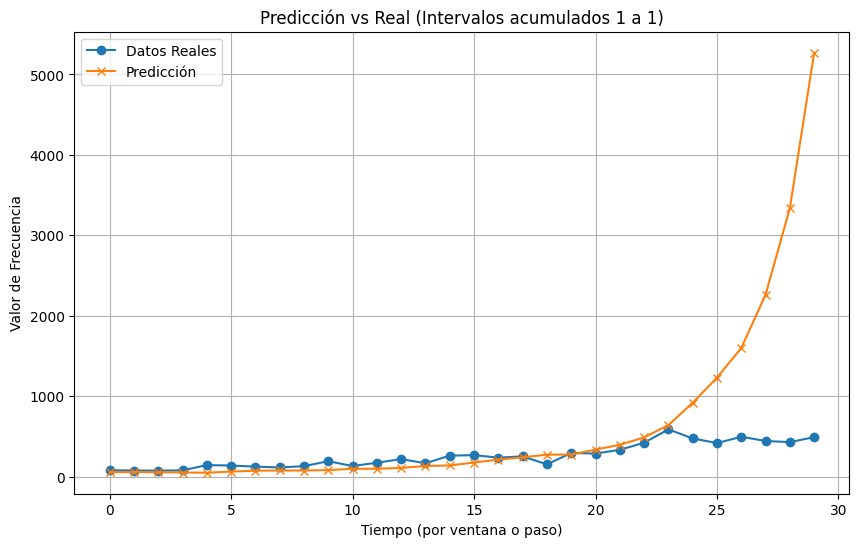

Iteración 2: Mejor época = 11, Loss = 0.2257
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Acumulando intervalos 1 a 2: MAE = 86.64, MSE = 12765.41


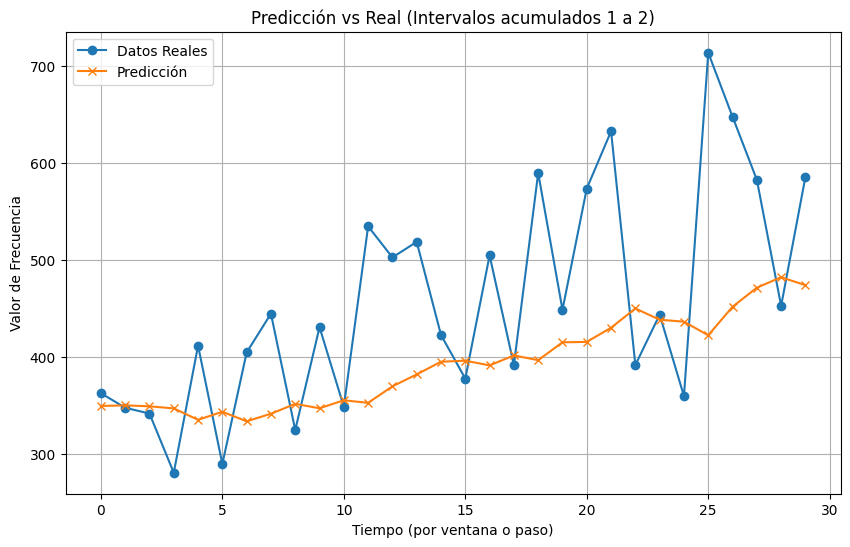

Iteración 3: Mejor época = 13, Loss = 0.1593
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Acumulando intervalos 1 a 3: MAE = 194.53, MSE = 65789.59


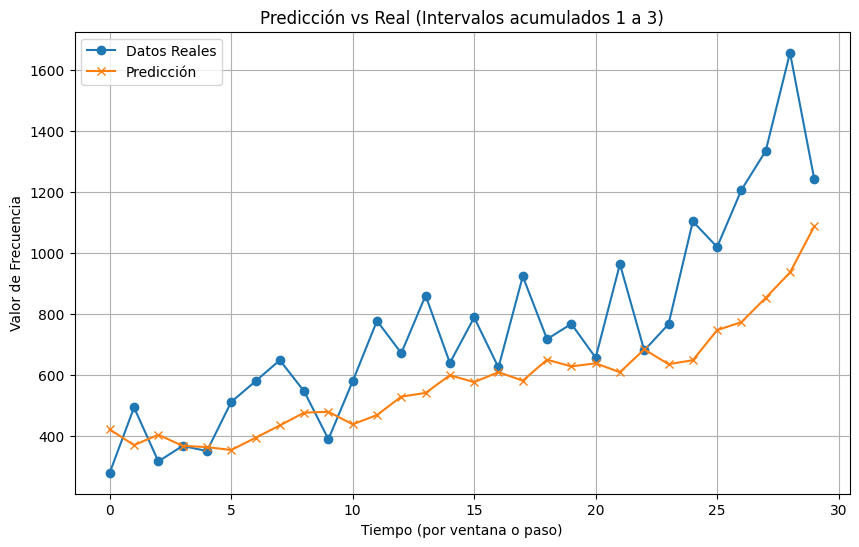

Iteración 4: Mejor época = 5, Loss = 0.2200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Acumulando intervalos 1 a 4: MAE = 92.49, MSE = 8586.97


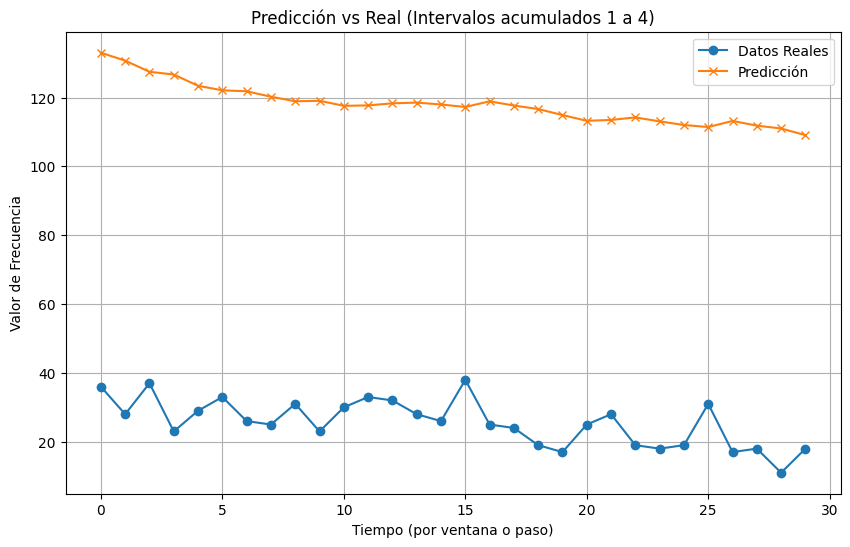

Iteración 5: Mejor época = 14, Loss = 0.1795
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Acumulando intervalos 1 a 5: MAE = 86.49, MSE = 13403.49


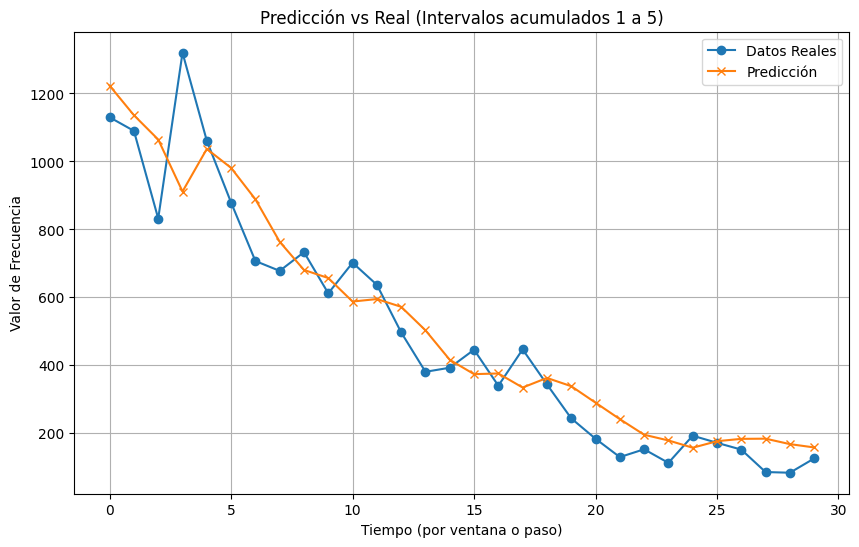

Iteración 6: Mejor época = 17, Loss = 0.1769
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Acumulando intervalos 1 a 6: MAE = 42.86, MSE = 2187.07


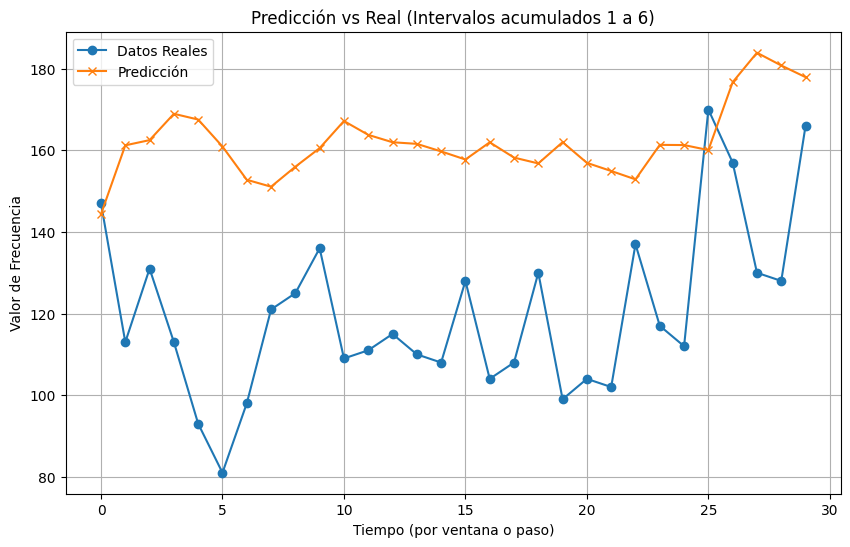

Iteración 7: Mejor época = 10, Loss = 0.2072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Acumulando intervalos 1 a 7: MAE = 69.37, MSE = 4975.66


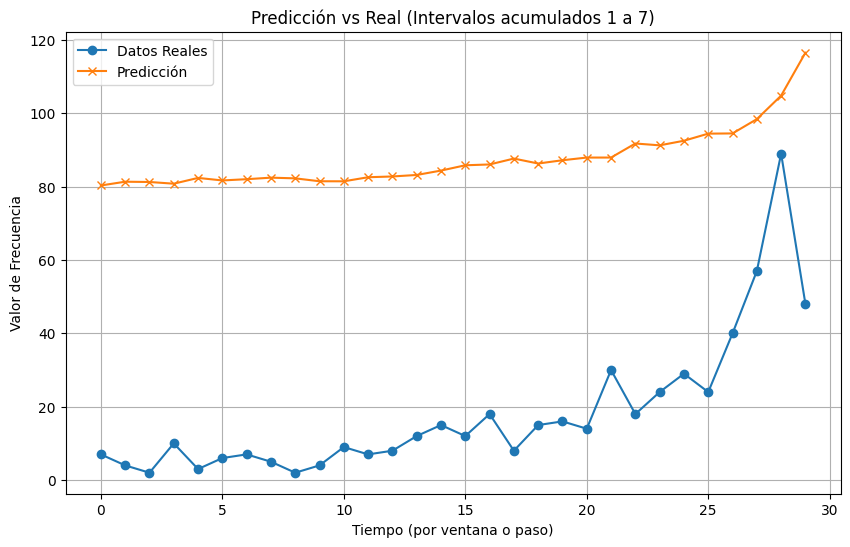

Iteración 8: Mejor época = 23, Loss = 0.1925
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Acumulando intervalos 1 a 8: MAE = 28.06, MSE = 796.71


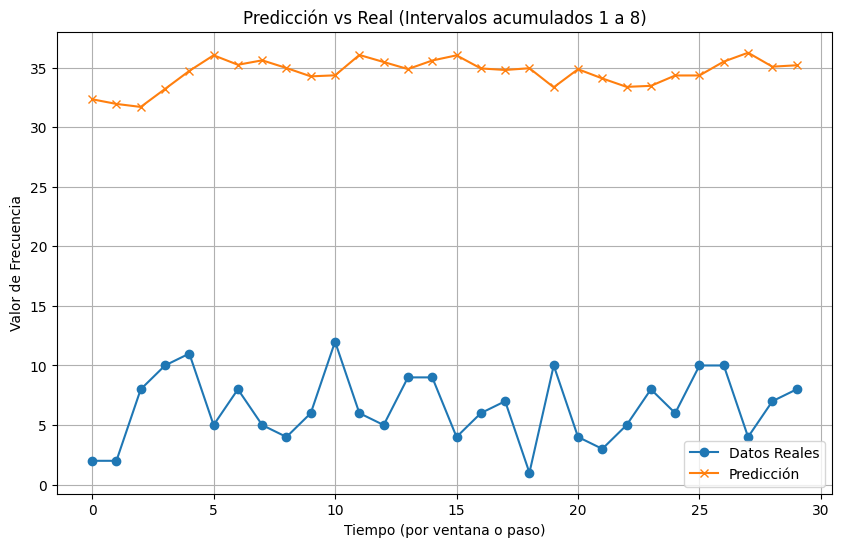


Resumen de métricas:
  Intervalos Acumulados         MAE           MSE       SMAPE
0      Intervalos 1 a 1  441.857612  1.226672e+06   55.657917
1      Intervalos 1 a 2   86.638127  1.276541e+04   18.982878
2      Intervalos 1 a 3  194.533989  6.578959e+04   27.113079
3      Intervalos 1 a 4   92.488724  8.586975e+03  129.685112
4      Intervalos 1 a 5   86.494989  1.340349e+04   22.681339
5      Intervalos 1 a 6   42.860173  2.187070e+03   31.333771
6      Intervalos 1 a 7   69.371739  4.975665e+03  141.123269
7      Intervalos 1 a 8   28.060211  7.967089e+02  138.275031


In [25]:
WINDOW_SIZE =  21
resultados = []

for i in range(len(intervalos_ordenados)):

    scaler = StandardScaler()
    model = build_lstm_model(WINDOW_SIZE) # Incializar el modelo LSTM


    # Tomando intervalo por intervalo
    intervalos_incluir = intervalos_ordenados[:i+1]
    df_accu = df[df['Intervalo'].isin(intervalos_incluir)]
    df_accu = df_accu.sort_values(by='Fecha')
    series = df_accu['Frecuencia'].values.reshape(-1, 1)

    # Normalizar los datos
    series_scaled = scaler.fit_transform(series)
    X,y = create_windows(series_scaled, window_size=WINDOW_SIZE)
    X_train , y_train = X[:-HORIZONTE_2], y[:-HORIZONTE_2]
    X_test , y_test = X[-HORIZONTE_2:], y[-HORIZONTE_2:]


    # Construimos y entrenamos el modelo
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es_cb],
        verbose=0
    )
    
    # 1) Encuentro la época de mínima pérdida
    loss_vals = history.history['loss']
    epochs_ran = len(loss_vals) 
    best_epoch = int(np.argmin(loss_vals)) + 1     
    best_loss = loss_vals[best_epoch-1]
    print(f"Iteración {i+1}: Mejor época = {best_epoch}, Loss = {best_loss:.4f}")

    # 2) Grafico la curva de entrenamiento y marco la mejor época
    plt.figure(figsize=(8,5))
    ax = plt.gca()  # obtenemos el eje actual
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  
    plt.plot(range(1, epochs_ran+1), loss_vals, marker='o', label='Training loss')
    plt.axvline(best_epoch, color='gray', linestyle='--', label=f'Best epoch ({best_epoch})')
    plt.title(f"Pérdida durante el entrenamiento\nIntervalos 1 a {i+1}")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # 3) Guardo la figura en la carpeta
    # Construir la ruta completa a la subcarpeta
    subfolder_path = os.path.join(loss_folder, "21_30_loss")
    # Crear la subcarpeta
    os.makedirs(subfolder_path, exist_ok=True)
    plot_path = os.path.join(subfolder_path, f"21_30_loss_intervalos_1_{i+1}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close() 

    
    # Hacemos la predicción para el conjunto test
    y_pred_scaled = model.predict(X_test)
    
    # Invertimos la transformación del escalador para volver a los valores originales
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
    
    # Calculamos las métricas
    mae = mean_absolute_error(y_test_inv, y_pred)
    mse = mean_squared_error(y_test_inv, y_pred)
    smape_value = smape(y_test_inv, y_pred)

    resultados.append({
        'Intervalos Acumulados': f"Intervalos 1 a {i+1}",
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape_value
    })
    
    print(f"Acumulando intervalos 1 a {i+1}: MAE = {mae:.2f}, MSE = {mse:.2f}")
    
    # Graficar datos reales vs predicción para este intervalo
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inv, label="Datos Reales", marker='o')
    plt.plot(y_pred, label="Predicción", marker='x')
    plt.title(f"Predicción vs Real (Intervalos acumulados 1 a {i+1})")
    plt.xlabel("Tiempo (por ventana o paso)")
    plt.ylabel("Valor de Frecuencia")
    plt.legend()
    plt.grid(True)
    plt.show()


df_resultados = pd.DataFrame(resultados)
print("\nResumen de métricas:")
print(df_resultados) 


subfolder1_path = os.path.join(result_folder, "21_30_results")
os.makedirs(subfolder1_path, exist_ok=True)


# Ruta completa al archivo dentro de la subcarpeta
csv_path = os.path.join(subfolder1_path, "lstm_21_30.csv")

# Guardar el DataFrame en esa ruta
df_resultados.to_csv(csv_path, index=False)
